<a href="https://colab.research.google.com/github/Gustavoq14/Optimization-Algorithms/blob/main/Benchmarking_Self_cooling_Simulated_Annealing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import time

from scipy.stats import truncnorm

# 2. Functions

In [ ]:
def chi2(datos, funcion, sigma, params):
  if np.isscalar(sigma) and sigma == 0:
        sigma = 1
  else:
        sigma[sigma == 0] = 1
  return np.sum(np.power((datos-funcion)/sigma,2))/(np.size(datos)-(len(params[0])+len(params[1])))

def grad_chi2(datos, funcion, sigma, gradiente, params):
  return np.array([-2*np.sum((datos - funcion)/np.power(sigma,2)*gradiente[i]) for i in range(len(gradiente))])/(np.size(datos)-(len(params[0])+len(params[1])))

def hess_chi2(datos, funcion, sigma, gradiente, hessiana, params):
  #return np.array([[2*np.sum((-datos*hessiana[i][j] + gradiente[i]*gradiente[j] + datos*hessiana[i][j])/np.power(sigma, 2)) for j in range(hessiana.shape[1])] for i in range(hessiana.shape[0])])/(np.size(datos)-(len(params[0])+len(params[1])))
  return np.array([[2*np.sum((-datos*hessiana[i][j] + gradiente[i]*gradiente[j] + funcion*hessiana[i][j])/np.power(sigma, 2)) for j in range(hessiana.shape[1])] for i in range(hessiana.shape[0])])/(np.size(datos)-(len(params[0])+len(params[1])))

def funcion_1(x, params):
  A, C, E = params[0][0], params[0][1], params[0][2]
  B, D = params[1][0], params[1][1]
  return A*np.cos(B*x)+C*np.sin(D*x)+E

def bases_1(x, params):
  B, D = params[0], params[1]
  return np.array([np.cos(B*x), np.sin(D*x), np.ones_like(x)])

def grad_funcion_1(x, params):
  A, C = params[0][0], params[0][1]
  B, D = params[1][0], params[1][1]
  df_dB = -A*x*np.sin(B*x)
  df_dD =  C*x*np.cos(D*x)
  return np.array([df_dB, df_dD])

def hess_funcion_1(x, params):
  A, C = params[0][0], params[0][1]
  B, D = params[1][0], params[1][1]
  df2_dB2 = -A*np.power(x,2)*np.cos(B*x)
  df2_dBdD = np.zeros_like(x)
  df2_dD2 = -C*np.power(x,2)*np.sin(D*x)
  return np.array([[df2_dB2, df2_dBdD], [df2_dBdD, df2_dD2]])

def gauss1(x, params):
  b1, b3, b6 = params[0][0], params[0][1], params[0][2]
  b2, b4, b5, b7, b8 = params[1][0], params[1][1], params[1][2], params[1][3], params[1][4]
  return  b1*np.exp(-b2*x)+b3*np.exp(-np.power(x-b4, 2)/pow(b5, 2))+b6*np.exp(-np.power(x-b7, 2)/pow(b8, 2))

def bases_gauss1(x, params):
  b2, b4, b5, b7, b8 = params[0], params[1], params[2], params[3], params[4]
  return np.array([np.exp(-b2*x), np.exp(-np.power(x-b4, 2)/pow(b5, 2)), np.exp(-np.power(x-b7, 2)/pow(b8, 2))])

def grad_gauss1(x, params):
  b1, b3, b6 = params[0][0], params[0][1], params[0][2]
  b2, b4, b5, b7, b8 = params[1][0], params[1][1], params[1][2], params[1][3], params[1][4]
  df_db2 = -b1*x*np.exp(-b2*x)
  df_db4 = 2*b3*np.exp(-np.power(x-b4, 2)/pow(b5, 2))*(x-b4)/pow(b5, 2)
  df_db5 = 2*b3*np.exp(-np.power(x-b4, 2)/pow(b5, 2))*pow(x-b4,2)/pow(b5, 3)
  df_db7 = 2*b6*np.exp(-np.power(x-b7, 2)/pow(b8, 2))*(x-b7)/pow(b8, 2)
  df_db8 = 2*b6*np.exp(-np.power(x-b7, 2)/pow(b8, 2))*pow(x-b7,2)/pow(b8, 3)
  df_db9 = np.zeros_like(x)
  return np.array([df_db2, df_db4, df_db5, df_db7, df_db8])

def hess_gauss1(x, params):
  b1, b3, b6 = params[0][0], params[0][1], params[0][2]
  b2, b4, b5, b7, b8 = params[1][0], params[1][1], params[1][2], params[1][3], params[1][4]
  df2_db22 = b1*np.power(x,2)*np.exp(-b2*x)
  zero = np.zeros_like(x)
  df2_db42 = 2*b3*np.exp(-np.power(x-b4,2)/pow(b5, 2))*(-4*b4*x+2*pow(b4,2)-pow(b5,2)+2*np.power(x,2))/pow(b5,4)
  df2_db4db5 = 4*b3*np.exp(-np.power(x-b4,2)/pow(b5,2))*(x-b4)*(-2*b4*x+pow(b4,2)-pow(b5,2)+np.power(x,2))/pow(b5,5)
  df2_db5db4 = df2_db4db5
  df2_db52 = 2*b3*np.exp(-np.power(x-b4, 2)/pow(b5,2))*np.power(x-b4,2)*(-4*b4*x+2*pow(b4,2)-3*pow(b5,2)+2*np.power(x,2))/pow(b5,6)
  df2_db72 = 2*b6*np.exp(-np.power(x-b7,2)/pow(b8, 2))*(-4*b7*x+2*pow(b7,2)-pow(b8,2)+2*np.power(x,2))/pow(b8,4)
  df2_db7db8 = 4*b6*np.exp(-np.power(x-b7,2)/pow(b8,2))*(x-b7)*(-2*b7*x+pow(b7,2)-pow(b8,2)+np.power(x,2))/pow(b8,5)
  df2_db8db7 = df2_db7db8
  df2_db82 = 2*b6*np.exp(-np.power(x-b7, 2)/pow(b8,2))*np.power(x-b7,2)*(-4*b7*x+2*pow(b7,2)-3*pow(b8,2)+2*np.power(x,2))/pow(b8,6)
  M_1 = [df2_db22, zero, zero, zero, zero]
  M_2 = [zero, df2_db42, df2_db4db5, zero, zero]
  M_3 = [zero, df2_db5db4, df2_db52, zero, zero]
  M_4 = [zero, zero, zero, df2_db72, df2_db7db8]
  M_5 = [zero, zero, zero, df2_db8db7, df2_db82]
  return np.array([M_1, M_2, M_3, M_4, M_5])

def mgh17(x, params):
  b1, b2, b3 = params[0][0], params[0][1], params[0][2]
  b4, b5 = params[1][0], params[1][1]
  return b1 + b2*np.exp(-b4*x) + b3*np.exp(-b5*x)

def bases_mgh17(x, params):
  b4, b5 = params[0], params[1]
  return np.array([np.ones_like(x), np.exp(-b4*x), np.exp(-b5*x)])

def grad_mgh17(x, params):
  b1, b2, b3 = params[0][0], params[0][1], params[0][2]
  b4, b5 = params[1][0], params[1][1]
  df_db4 = -b2*x*np.exp(-b4*x)
  df_db5 = -b3*x*np.exp(-b5*x)
  return np.array([df_db4, df_db5])

def hess_mgh17(x, params):
  b1, b2, b3 = params[0][0], params[0][1], params[0][2]
  b4, b5 = params[1][0], params[1][1]
  df2_db42 = b2*np.power(x,2)*np.exp(-b4*x)
  df2_db4db5 = np.zeros_like(x)
  df2_db52 = b3*np.power(x,2)*np.exp(-b5*x)
  return np.array([[df2_db42, df2_db4db5], [df2_db4db5, df2_db52]])

def rat42(x, params):
  b1 = params[0][0]
  b2, b3 = params[1][0], params[1][1]
  return b1*(np.power(1+np.exp(b2-b3*x), -1))

def bases_rat42(x, params):
  b2, b3 = params[0], params[1]
  return np.array([np.power(1+np.exp(b2-b3*x), -1)])

def grad_rat42(x, params):
  b1 = params[0][0]
  b2, b3 = params[1][0], params[1][1]
  df_db2 = -b1*np.exp(b2-b3*x)*np.power(np.exp(b2-b3*x)+1,-2)
  df_db3 = b1*x*np.exp(b2-b3*x)*np.power(np.exp(b2-b3*x)+1,-2)
  return np.array([df_db2, df_db3])

def hess_rat42(x, params):
  b1 = params[0][0]
  b2, b3 = params[1][0], params[1][1]
  df2_db22 = -b1*np.exp(b2+b3*x)*(np.exp(b3*x)-np.exp(b2))*np.power(np.exp(b3*x)+np.exp(b2),-3)
  df2_db2db3 = b1*x*np.exp(b2+b3*x)*(np.exp(b3*x)-np.exp(b2))*np.power(np.exp(b3*x)+np.exp(b2),-3)
  df2_db32 = b1*np.power(x,2)*np.exp(b2+b3*x)*(np.exp(b3*x)-np.exp(b2))*np.power(np.exp(b3*x)+np.exp(b2),-3)
  return np.array([[df2_db22, df2_db2db3], [df2_db2db3, df2_db32]])

def lanczos3(x, params):
  b1, b3, b5 = params[0][0], params[0][1], params[0][2]
  b2, b4, b6 = params[1][0], params[1][1], params[1][2]
  return b1*np.exp(-b2*x)+b3*np.exp(-b4*x)+b5*np.exp(-b6*x)

def bases_lanczos3(x, params):
  b2, b4, b6 = params[0], params[1], params[2]
  return np.array([np.exp(-b2*x), np.exp(-b4*x), np.exp(-b6*x)])

def grad_lanczos3(x, params):
  b1, b3, b5 = params[0][0], params[0][1], params[0][2]
  b2, b4, b6 = params[1][0], params[1][1], params[1][2]
  df_db2 = -b1*x*np.exp(-b2*x)
  df_db4 = -b3*x*np.exp(-b4*x)
  df_db6 = -b5*x*np.exp(-b6*x)
  return np.array([df_db2, df_db4, df_db6])

def hess_lanczos3(x, params):
  b1, b3, b5 = params[0][0], params[0][1], params[0][2]
  b2, b4, b6 = params[1][0], params[1][1], params[1][2]
  df2_db22 = b1*np.power(x,2)*np.exp(-b2*x)
  df2_db42 = b3*np.power(x,2)*np.exp(-b4*x)
  df2_db62 = b5*np.power(x,2)*np.exp(-b6*x)
  zero = np.zeros_like(x)
  return np.array([[df2_db22, zero, zero], [zero, df2_db42, zero], [zero, zero, df2_db62]])

def Bzm(chi_1, chi_2, T):
    return np.exp(-(chi_1-chi_2)/T)

def T_bath(T):
    if T < 10:
        cte = 1.
    else:
        cte = np.log10(T)
    return T/cte

def Temp(k_c, Tmin, Ti):
    return Ti + k_c * (Tmin - Ti)

def leer_resultados(filename):
    with open(filename, 'r') as file:
        header = file.readline().strip().split('\t')
    data = {col: [] for col in header}
    with open(filename, 'r') as file:
        next(file)
        for line in file:
            values = line.strip().split('\t')
            for col, value in zip(header, values):
                if col in ('beta', 'gamma'):
                    data[col].append([float(v) for v in value.split(', ')])
                elif col in ('chi', 'T'):
                    data[col].append(float(value))
                else:
                    data[col].append(int(value))
    df = pd.DataFrame(data)
    return df

def calculate_limits(data_columns, df_chi, bins=30):
    all_data = np.concatenate([df_chi[column].values for column in data_columns])
    x_range = (all_data.min(), all_data.max())

    y_max = max([np.histogram(df_chi[column], bins=bins)[0].max()
                 for column in data_columns])

    return x_range, y_max

def truncated_normal(centers, vars, lowers, uppers):
    stds = np.sqrt(vars)
    a = (lowers - centers) / stds
    b = (uppers - centers) / stds
    return truncnorm.rvs(a, b, loc=centers, scale=stds)

# 3. Data Fitting Methods

In [ ]:
def coef_lineal(datos, bases, sigma):
    """
    Versión optimizada de coef_lineal. Mantiene validaciones pero acelera operaciones clave.
    """
    try:
        # Conversión rápida a arrays (evita copias si ya son arrays)
        datos = np.asarray(datos, dtype=np.float64)
        bases = np.asarray(bases, dtype=np.float64)
        sigma = np.asarray(sigma, dtype=np.float64)

        # Validación unificada de NaN/inf (usa operaciones vectorizadas)
        if np.any(~np.isfinite(datos)) or np.any(~np.isfinite(bases)) or np.any(~np.isfinite(sigma)):
            return None

        # Cálculo optimizado de inv_sigma (evita máscaras temporales)
        inv_sigma = np.ones_like(sigma)
        np.divide(1.0, sigma, out=inv_sigma, where=(sigma != 0))

        # Construcción eficiente de A (elige transpuesta solo si es necesario)
        A = bases.T if bases.shape[0] < bases.shape[1] else bases
        A_weighted = np.multiply(A, inv_sigma[:, np.newaxis])  # Más rápido que inv_sigma[:, None]

        # Mínimos cuadrados con verificación compacta
        x, _, rank, _ = np.linalg.lstsq(A_weighted, datos * inv_sigma, rcond=None)
        return x if rank == A_weighted.shape[1] and np.all(np.isfinite(x)) else None

    except (np.linalg.LinAlgError, ValueError, TypeError, RuntimeWarning) as e:
        return None  # Silencioso en producción (opcional: añadir logging)


def svd_inverse(matrix, tol=None):
    U, s, Vh = np.linalg.svd(matrix, full_matrices=False)
    if tol is None:
        tol = np.finfo(s.dtype).eps * max(matrix.shape) * s[0]
    mask = s > tol
    s_inv = np.zeros_like(s)
    s_inv[mask] = 1.0 / s[mask]
    return (Vh.T * s_inv) @ U.T

## 3.1 Monte Carlo Gradient Descent

In [ ]:
def mc_gd(x, datos, funcion, sigma, bases, gradiente, params_nl, target, imax = 1000, kmax = 1000, eta = 0.01, tol = 1e-4, filename = 'mc_gd'):
  results = []
  chi = []
  c = 0
  e = 0
  for i in range(imax):
    if i % 100 == 0:
        gamma_0 = target
    else:
        gamma_0 = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])
    B_0 = bases(x, gamma_0)
    beta_0 = coef_lineal(datos, B_0, sigma)
    f_0 = np.dot(beta_0, B_0)
    theta_0 = (beta_0, gamma_0)
    theta_opt = theta_0
    chi_opt = chi2(datos, f_0, sigma, theta_0)
    theta_bus = theta_0
    chi_bus = chi2(datos, f_0, sigma, theta_0)

    k = 0
    s = 0
    gamma_k = gamma_0
    beta_k = beta_0
    chi.append(chi_opt)
    dif = 1

    beta_0_str = ", ".join(map(str, theta_0[0]))
    gamma_0_str = ", ".join(map(str, theta_0[1]))
    results.append(f"{i}\t{0}\t{beta_0_str}\t{gamma_0_str}\t{chi_bus}\n")
    while k < kmax and dif > tol:
      grad = grad_chi2(datos, funcion(x, [beta_k, gamma_k]), sigma, gradiente(x, [beta_k, gamma_k]), [beta_k, gamma_k])
      gamma_k -= eta * grad / np.linalg.norm(grad)
      if all(gamma_k[j] < params_nl[j][0] or gamma_k[j] > params_nl[j][1] for j in range(len(gamma_k))) or any(np.isnan(gamma_k)) or any(np.isinf(gamma_k)):
          c += 1
          break
      B_k = bases(x, gamma_k)
      beta_k = coef_lineal(datos, B_k, sigma)
      if beta_k is None:
          e += 1
          break
      f_k = np.dot(beta_k, B_k)
      chi_nue = chi2(datos, f_k, sigma, [beta_k, gamma_k])
      if chi_nue < chi_opt:
        theta_opt = (beta_k.copy(), gamma_k.copy())
        chi_opt = chi_nue
        chi.append(chi_opt)
        s += 1
        dif = abs(chi[s]-chi[s-1])
      beta_k_str = ", ".join(map(str, beta_k.tolist()))
      gamma_k_str = ", ".join(map(str, gamma_k.tolist()))
      results.append(f"{i}\t{k}\t{beta_k_str}\t{gamma_k_str}\t{chi_nue}\n")
      k += 1

  print(f'Cantidad de reinicios cuyos parametrós salieron del intervalo: {c}')
  print(f'Cantidad de veces que SVD no convergió en Mínimos Cuadrados Lineales: {e}')
  with open(filename, 'w') as file:
    file.write("i\tk\tbeta\tgamma\tchi\n")
    file.writelines(results)

## 3.2 Monte Carlo Newton-Raphson

In [ ]:
def mc_nr(x, datos, funcion, sigma, bases, gradiente, hessiana, params_nl, target, imax = 1000, kmax = 1000, tol = 1e-4, filename = 'mc_nr'):
  results = []
  chi = []
  c = 0
  e = 0
  for i in range(imax):
    if i % 100 == 0:
      gamma_0 = target
    else:
      gamma_0 = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])
    B_0 = bases(x, gamma_0)
    beta_0 = coef_lineal(datos, B_0, sigma)
    f_0 = np.dot(beta_0, B_0)
    theta_0 = (beta_0, gamma_0)
    theta_opt = theta_0
    chi_opt = chi2(datos, f_0, sigma, theta_0)
    theta_bus = theta_0
    chi_bus = chi2(datos, f_0, sigma, theta_0)

    k = 0
    s = 0
    gamma_k = gamma_0
    beta_k = beta_0
    chi.append(chi_opt)
    dif = 1

    beta_0_str = ", ".join(map(str, theta_0[0]))
    gamma_0_str = ", ".join(map(str, theta_0[1]))
    results.append(f"{i}\t{0}\t{beta_0_str}\t{gamma_0_str}\t{chi_bus}\n")
    while k < kmax and dif > tol:
      grad = grad_chi2(datos, funcion(x, [beta_k, gamma_k]), sigma, gradiente(x, [beta_k, gamma_k]), [beta_k, gamma_k])
      H = hess_chi2(datos, funcion(x, [beta_k, gamma_k]), sigma, gradiente(x, [beta_k, gamma_k]), hessiana(x, [beta_k, gamma_k]), [beta_k, gamma_k])
      H_inv = svd_inverse(H)
      if np.isnan(H_inv).any() or np.isinf(H_inv).any():
          break
      gamma_k -= H_inv @ grad
      if all(gamma_k[j] < params_nl[j][0] or gamma_k[j] > params_nl[j][1] for j in range(len(gamma_k))) or any(np.isnan(gamma_k)) or any(np.isinf(gamma_k)):
          c += 1
          break
      B_k = bases(x, gamma_k)
      beta_k = coef_lineal(datos, B_k, sigma)
      if beta_k is None:
          e += 1
          break
      f_k = np.dot(beta_k, B_k)
      chi_nue = chi2(datos, f_k, sigma, [beta_k, gamma_k])
      if chi_nue < chi_opt:
        theta_opt = (beta_k.copy(), gamma_k.copy())
        chi_opt = chi_nue
        chi.append(chi_opt)
        s += 1
        dif = abs(chi[s] - chi[s-1])
      beta_k_str = ", ".join(map(str, beta_k.tolist()))
      gamma_k_str = ", ".join(map(str, gamma_k.tolist()))
      results.append(f"{i}\t{k}\t{beta_k_str}\t{gamma_k_str}\t{chi_nue}\n")
      k += 1

  print(f'Cantidad de reinicios cuyos parametrós salieron del intervalo: {c}')
  print(f'Cantidad de veces que SVD no convergió en Mínimos Cuadrados Lineales: {e}')
  with open(filename, 'w') as file:
    file.write("i\tk\tbeta\tgamma\tchi\n")
    file.writelines(results)

## 3.3 Monte Carlo Levenberg-Marquardt

In [ ]:
def mc_lm(x, datos, funcion, sigma, bases, gradiente, hessiana, params_nl, target,
           imax=1000, kmax=1000, l=1.0, tol=1e-5, filename='mc_lm'):
    """
    Método de Levenberg–Marquardt Monte Carlo (versión robusta mejorada con svd_inverse):
    - Mantiene el bloque original con M = H + λI y svd_inverse(M)
    - Gestión suave de lambda (×0.5 o ×2.0)
    - Criterio de parada basado en norma del paso Δγ
    - Conserva los controles de rango y fallos SVD
    """
    results = []
    chi = []
    c = 0  # Contador de parámetros fuera de rango
    e = 0  # Contador de errores en SVD o mínimos cuadrados

    for i in range(imax):
        # --- Inicialización de parámetros no lineales ---
        if i % 100 == 0:
            gamma_k = target.copy()
        else:
            gamma_k = np.array([np.random.uniform(p[0], p[1]) for p in params_nl])

        B_0 = bases(x, gamma_k)
        beta_k = coef_lineal(datos, B_0, sigma)
        if beta_k is None:
            e += 1
            continue

        f_k = np.dot(beta_k, B_0)
        chi_opt = chi2(datos, f_k, sigma, [beta_k, gamma_k])
        theta_opt = (beta_k.copy(), gamma_k.copy())
        chi_iter = [chi_opt]

        # --- Logging inicial ---
        beta_str = ", ".join(map(str, beta_k))
        gamma_str = ", ".join(map(str, gamma_k))
        results.append(f"{i}\t{0}\t{beta_str}\t{gamma_str}\t{chi_opt}\n")

        for k in range(kmax):
            # --- Gradiente y Hessiana ---
            grad = grad_chi2(datos, funcion(x, [beta_k, gamma_k]), sigma,
                             gradiente(x, [beta_k, gamma_k]), [beta_k, gamma_k])
            H = hess_chi2(datos, funcion(x, [beta_k, gamma_k]), sigma,
                          gradiente(x, [beta_k, gamma_k]), hessiana(x, [beta_k, gamma_k]), [beta_k, gamma_k])

            # --- Paso LM con tu bloque original ---
            In = l * np.identity(H.shape[0])
            M = H + In
            M_inv = svd_inverse(M)
            if np.isnan(M_inv).any() or np.isinf(M_inv).any():
                e += 1
                break

            delta = M_inv @ grad
            gamma_new = gamma_k - delta

            # --- Verificación de rango de parámetros ---
            if any(gamma_new[j] < params_nl[j][0] or gamma_new[j] > params_nl[j][1]
                   for j in range(len(gamma_new))):
                c += 1
                break

            # --- Recalcular modelo ---
            B_new = bases(x, gamma_new)
            beta_new = coef_lineal(datos, B_new, sigma)
            if beta_new is None:
                e += 1
                break

            f_new = np.dot(beta_new, B_new)
            chi_new = chi2(datos, f_new, sigma, [beta_new, gamma_new])

            # --- Criterio de mejora ---
            if chi_new < chi_iter[-1]:
                gamma_k = gamma_new
                beta_k = beta_new
                chi_iter.append(chi_new)
                theta_opt = (beta_k.copy(), gamma_k.copy())
                chi_opt = chi_new
                l *= 0.1   # 0.5 ↓ Disminuye lambda (mayor paso)
            else:
                l *= 10  # 2 ↑ Aumenta lambda (menor paso)

            # --- Control de límites de lambda ---
            l = min(max(l, 1e-6), 1e4)

            # --- Criterio de convergencia por norma de Δγ ---
            if np.linalg.norm(delta) < tol:
                break

            # --- Logging ---
            beta_str = ", ".join(map(str, beta_k.tolist()))
            gamma_str = ", ".join(map(str, gamma_k.tolist()))
            results.append(f"{i}\t{k}\t{beta_str}\t{gamma_str}\t{chi_new}\n")

        # --- Guardar mejor chi² de este ciclo ---
        chi.append(chi_opt)

    # --- Estadísticas finales ---
    print(f'Cantidad de reinicios cuyos parámetros salieron del intervalo: {c}')
    print(f'Cantidad de veces que SVD no convergió en mínimos cuadrados lineales: {e}')

    # --- Escritura de resultados ---
    with open(filename, 'w') as file:
        file.write("i\tk\tbeta\tgamma\tchi\n")
        file.writelines(results)

## 3.4 Monte Carlo Acceptance-Rejection

In [ ]:
def mc_ar(x, datos, sigma, bases, params_nl, imax=1000, kmax=1000, filename='mc_ar'):
    results = []
    for i in range(imax):
        gamma_0 = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])
        B_0 = bases(x, gamma_0)
        beta_0 = coef_lineal(datos, B_0, sigma)
        f_0 = np.dot(beta_0, B_0)
        theta_0 = (beta_0, gamma_0)
        theta_opt = theta_0
        chi_opt = chi2(datos, f_0, sigma, theta_0)
        theta_bus = theta_0
        chi_bus = chi2(datos, f_0, sigma, theta_0)

        beta_0_str = ", ".join(map(str, theta_0[0]))
        gamma_0_str = ", ".join(map(str, theta_0[1]))
        results.append(f"{i}\t{0}\t{beta_0_str}\t{gamma_0_str}\t{chi_bus}\n")

        for k in range(kmax):
            gamma_k = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])
            B_k = bases(x, gamma_k)
            beta_k = coef_lineal(datos, B_k, sigma)
            f_k = np.dot(beta_k, B_k)
            theta_k = (beta_k, gamma_k)
            theta_bus = theta_k
            chi_nue = chi2(datos, f_k, sigma, theta_k)

            if chi_nue < chi_opt:
                theta_opt = theta_k
                chi_opt = chi_nue

            beta_k_str = ", ".join(map(str, theta_k[0]))
            gamma_k_str = ", ".join(map(str, theta_k[1]))
            results.append(f"{i}\t{k}\t{beta_k_str}\t{gamma_k_str}\t{chi_nue}\n")

    with open(filename, 'w') as file:
        file.write("i\tk\tbeta\tgamma\tchi\n")
        file.writelines(results)

## 3.5 Monte Carlo Simulated Annealing

In [ ]:
def mc_sa(x, datos, sigma, bases, params_nl, target, imax=1000, kmax=1000, t0 = 1000, alpha = 0.99, filename="mc_sa"):
    results = []
    for i in range(imax):
        if i % 100 == 0:
          gamma_0 = target
        else:
          gamma_0 = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])
        B_0 = bases(x, gamma_0)
        beta_0 = coef_lineal(datos, B_0, sigma)
        f_0 = np.dot(beta_0, B_0)
        theta_0 = (beta_0, gamma_0)

        theta_opt = theta_0
        chi_opt = chi2(datos, f_0, sigma, theta_0)
        theta_bus = theta_0
        chi_bus = chi2(datos, f_0, sigma, theta_0)
        T = t0

        beta_0_str = ", ".join(map(str, theta_0[0]))
        gamma_0_str = ", ".join(map(str, theta_0[1]))
        results.append(f"{i}\t{0}\t{beta_0_str}\t{gamma_0_str}\t{chi_bus}\t{T}\n")

        for k in range(kmax):
            gamma_k = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])
            B_k = bases(x, gamma_k)
            beta_k = coef_lineal(datos, B_k, sigma)
            f_k = np.dot(beta_k, B_k)
            theta_k = (beta_k, gamma_k)
            theta_bus = theta_k
            chi_nue = chi2(datos, f_k, sigma, theta_k)

            if chi_nue < chi_opt:
                chi_opt = chi_nue
                theta_opt = theta_k
            else:
                if np.random.uniform(0, 1) < Bzm(chi_nue, chi_opt, T):
                    chi_opt = chi_nue
                    theta_opt = theta_k


            beta_k_str = ", ".join(map(str, theta_k[0]))
            gamma_k_str = ", ".join(map(str, theta_k[1]))
            results.append(f"{i}\t{k}\t{beta_k_str}\t{gamma_k_str}\t{chi_nue}\t{T}\n")
            T *= alpha
    with open(filename, 'w') as file:
        file.write("i\tk\tbeta\tgamma\tchi\tT\n")
        file.writelines(results)

## 3.6 Monte Carlo Self-Cooling Simulated Annealing

In [ ]:
'''
def mc_scsa(x, datos, sigma, bases, params_nl, target, k_c = 0.1, imax = 1000, kmax = 1000, filename = 'mc_scsa'):
  results = []
  var = [(params_nl[j][1] - params_nl[j][0])*0.1 for j in range(len(params_nl))]
  for i in range(imax):
    if i % 100 == 0:
      gamma_0 = target
    else:
      gamma_0 = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])
    B_0 = bases(x, gamma_0)
    beta_0 = coef_lineal(datos, B_0, sigma)
    f_0 = np.dot(beta_0, B_0)
    theta_0 = (beta_0, gamma_0)
    theta_opt = theta_0
    chi_opt = chi2(datos, f_0, sigma, theta_0)
    theta_bus = theta_0
    chi_bus = chi2(datos, f_0, sigma, theta_0)
    T_ext = T_bath(chi_opt)
    T = T_ext

    beta_0_str = ", ".join(map(str, theta_0[0]))
    gamma_0_str = ", ".join(map(str, theta_0[1]))
    results.append(f"{i}\t{0}\t{beta_0_str}\t{gamma_0_str}\t{chi_bus}\t{T}\n")
    for k in range(kmax):
      gamma_k = np.array([np.random.normal(theta_bus[1][j], var[j]) for j in range(len(var))])
      while not np.all([limite[0] <= valor <= limite[1] for valor, limite in zip(gamma_k, params_nl)]):
        gamma_k = np.array([np.random.normal(theta_bus[1][j], var[j]) for j in range(len(var))])
      #gamma_k = truncated_normal(theta_bus[1], np.array(var), np.array(params_nl)[:, 0], np.array(params_nl)[:, 1])
      B_k = bases(x, gamma_k)
      beta_k = coef_lineal(datos, B_k, sigma)
      f_k = np.dot(beta_k, B_k)
      theta_k = (beta_k, gamma_k)
      theta_bus = theta_k
      chi_nue = chi2(datos, f_k, sigma, theta_k)
      if chi_nue < chi_opt:
        chi_opt = chi_nue
        theta_opt = theta_k
        T_ext = T_bath(chi_opt)
      else:
        if np.random.uniform(0,1) < Bzm(chi_nue, chi_opt, T):
          chi_opt = chi_nue
          theta_opt = theta_k

      beta_k_str = ", ".join(map(str, theta_k[0]))
      gamma_k_str = ", ".join(map(str, theta_k[1]))
      results.append(f"{i}\t{k}\t{beta_k_str}\t{gamma_k_str}\t{chi_nue}\t{T}\n")
      T = Temp(k_c, T_ext, T)

  with open(filename, 'w') as file:
    file.write("i\tk\tbeta\tgamma\tchi\tT\n")
    file.writelines(results)
'''

def mc_scsa(x, datos, sigma, bases, params_nl, target, k_c=None, imax=1000, kmax=1000, filename='mc_scsa'):

    if k_c is None:
        k_c = 5 / kmax

    results = []
    var = [(params_nl[j][1] - params_nl[j][0]) * 0.1 for j in range(len(params_nl))]

    for i in range(imax):
        if i % 100 == 0:
            gamma_0 = target
        else:
            gamma_0 = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1])
                                for j in range(len(params_nl))])

        B_0 = bases(x, gamma_0)
        beta_0 = coef_lineal(datos, B_0, sigma)
        f_0 = np.dot(beta_0, B_0)
        theta_0 = (beta_0, gamma_0)

        theta_opt = theta_0
        chi_opt = chi2(datos, f_0, sigma, theta_0)
        theta_bus = theta_0
        chi_bus = chi2(datos, f_0, sigma, theta_0)

        # 🔹 Temperatura inicial adaptativa (de versión 2)
        T_ext = T_bath(chi_opt)
        T = T_ext * 1.5   # arranque más caliente

        beta_0_str = ", ".join(map(str, theta_0[0]))
        gamma_0_str = ", ".join(map(str, theta_0[1]))
        results.append(f"{i}\t{0}\t{beta_0_str}\t{gamma_0_str}\t{chi_bus}\t{T}\n")

        for k in range(kmax):
            gamma_k = np.array([np.random.normal(theta_bus[1][j], var[j])
                                for j in range(len(var))])
            while not np.all([limite[0] <= valor <= limite[1]
                              for valor, limite in zip(gamma_k, params_nl)]):
                gamma_k = np.array([np.random.normal(theta_bus[1][j], var[j])
                                    for j in range(len(var))])

            B_k = bases(x, gamma_k)
            beta_k = coef_lineal(datos, B_k, sigma)
            f_k = np.dot(beta_k, B_k)
            theta_k = (beta_k, gamma_k)
            theta_bus = theta_k
            chi_nue = chi2(datos, f_k, sigma, theta_k)

            if chi_nue < chi_opt:
                chi_opt = chi_nue
                theta_opt = theta_k
                # 🔹 Actualización adaptativa de T_ext (igual que versión 2)
                T_ext = T_bath(chi_opt)
            else:
                if np.random.uniform(0, 1) < Bzm(chi_nue, chi_opt, T):
                    chi_opt = chi_nue
                    theta_opt = theta_k

            beta_k_str = ", ".join(map(str, theta_k[0]))
            gamma_k_str = ", ".join(map(str, theta_k[1]))
            results.append(f"{i}\t{k}\t{beta_k_str}\t{gamma_k_str}\t{chi_nue}\t{T}\n")

            # 🔸 Actualización adaptativa de temperatura
            T = Temp(k_c, T_ext, T)

    with open(filename, 'w') as file:
        file.write("i\tk\tbeta\tgamma\tchi\tT\n")
        file.writelines(results)


## 3.7 Monte Carlo Self-Cooling Simulated Annealing Variable Variance

In [ ]:
'''
def mc_scsav(x, datos, sigma, bases, params_nl, target, k_c=0.1, imax=1000, kmax=1000, std_number = 3, n = 5, filename='mc_scsav'):
    results = []
    initial_var = [(params_nl[j][1] - params_nl[j][0]) * 0.1 for j in range(len(params_nl))]
    accepted_solutions = np.zeros((std_number, len(params_nl)))
    acceptance_counter = 0
    for i in range(imax):
        if i % 100 == 0:
            gamma_0 = target
        else:
            gamma_0 = np.array([np.random.uniform(params_nl[j][0], params_nl[j][1]) for j in range(len(params_nl))])

        B_0 = bases(x, gamma_0)
        beta_0 = coef_lineal(datos, B_0, sigma)
        f_0 = np.dot(beta_0, B_0)
        theta_0 = (beta_0, gamma_0)
        theta_opt = theta_0
        chi_opt = chi2(datos, f_0, sigma, theta_0)
        theta_bus = theta_0
        chi_bus = chi2(datos, f_0, sigma, theta_0)
        T_ext = T_bath(chi_opt)
        T = T_ext
        var = initial_var.copy()

        beta_0_str = ", ".join(map(str, theta_0[0]))
        gamma_0_str = ", ".join(map(str, theta_0[1]))
        results.append(f"{i}\t{0}\t{beta_0_str}\t{gamma_0_str}\t{chi_bus}\t{T}\n")

        for k in range(kmax):
            gamma_k = np.array([np.random.normal(theta_bus[1][j], var[j]) for j in range(len(var))])
            while not np.all([limite[0] <= valor <= limite[1] for valor, limite in zip(gamma_k, params_nl)]):
                gamma_k = np.array([np.random.normal(theta_bus[1][j], var[j]) for j in range(len(var))])
            #gamma_k = truncated_normal(theta_bus[1], np.array(var), np.array(params_nl)[:, 0], np.array(params_nl)[:, 1])
            B_k = bases(x, gamma_k)
            beta_k = coef_lineal(datos, B_k, sigma)
            f_k = np.dot(beta_k, B_k)
            theta_k = (beta_k, gamma_k)
            chi_nue = chi2(datos, f_k, sigma, theta_k)

            if chi_nue < chi_opt:
                chi_opt = chi_nue
                theta_opt = theta_k
                T_ext = T_bath(chi_opt)
                accepted_solutions[acceptance_counter % std_number] = gamma_k
                acceptance_counter += 1

            else:
                if np.random.uniform(0, 1) < Bzm(chi_nue, chi_opt, T):
                    chi_opt = chi_nue
                    theta_opt = theta_k
                    accepted_solutions[acceptance_counter % std_number] = gamma_k
                    acceptance_counter += 1

            if acceptance_counter >= std_number:
                    var = np.std(accepted_solutions, axis=0) * n  # Ajuste de la varianza


            beta_k_str = ", ".join(map(str, theta_k[0]))
            gamma_k_str = ", ".join(map(str, theta_k[1]))
            results.append(f"{i}\t{k}\t{beta_k_str}\t{gamma_k_str}\t{chi_nue}\t{T}\n")
            T = Temp(k_c, T_ext, T)

    with open(filename, 'w') as file:
        file.write("i\tk\tbeta\tgamma\tchi\tT\n")
        file.writelines(results)
'''
def mc_scsav(x, datos, sigma, bases, params_nl, target, k_c=0.1, imax=1000, kmax=1000, std_number=3, n=5, filename='mc_scsav'):
    results = []
    initial_var = [(params_nl[j][1] - params_nl[j][0]) * 0.1 for j in range(len(params_nl))]
    accepted_solutions = np.zeros((std_number, len(params_nl)))
    acceptance_counter = 0

    for i in range(imax):
        # Reinicio controlado cada 100 iteraciones
        if i % 100 == 0:
            gamma_0 = target
        else:
            gamma_0 = np.array([
                np.random.uniform(params_nl[j][0], params_nl[j][1])
                for j in range(len(params_nl))
            ])

        B_0 = bases(x, gamma_0)
        beta_0 = coef_lineal(datos, B_0, sigma)
        f_0 = np.dot(beta_0, B_0)
        theta_0 = (beta_0, gamma_0)
        theta_opt = theta_0
        chi_opt = chi2(datos, f_0, sigma, theta_0)
        theta_bus = theta_0
        chi_bus = chi_opt

        # --- Temperatura inicial adaptada como en versión 2 ---
        T_ext = T_bath(chi_opt)
        T = T_ext * 1.5  # arranque más alto para mayor exploración
        var = initial_var.copy()

        # Registro inicial
        beta_0_str = ", ".join(map(str, theta_0[0]))
        gamma_0_str = ", ".join(map(str, theta_0[1]))
        results.append(f"{i}\t{0}\t{beta_0_str}\t{gamma_0_str}\t{chi_bus}\t{T}\n")

        # --- Bucle interno Monte Carlo ---
        for k in range(kmax):
            gamma_k = np.array([np.random.normal(theta_bus[1][j], var[j]) for j in range(len(var))])
            # Forzar límites
            while not np.all([limite[0] <= valor <= limite[1] for valor, limite in zip(gamma_k, params_nl)]):
                gamma_k = np.array([np.random.normal(theta_bus[1][j], var[j]) for j in range(len(var))])

            B_k = bases(x, gamma_k)
            beta_k = coef_lineal(datos, B_k, sigma)
            f_k = np.dot(beta_k, B_k)
            theta_k = (beta_k, gamma_k)
            chi_nue = chi2(datos, f_k, sigma, theta_k)

            # --- Criterio de aceptación ---
            if chi_nue < chi_opt:
                chi_opt = chi_nue
                theta_opt = theta_k
                T_ext = T_bath(chi_opt)  # actualización sincronizada
                accepted_solutions[acceptance_counter % std_number] = gamma_k
                acceptance_counter += 1
            else:
                if np.random.uniform(0, 1) < Bzm(chi_nue, chi_opt, T):
                    chi_opt = chi_nue
                    theta_opt = theta_k
                    accepted_solutions[acceptance_counter % std_number] = gamma_k
                    acceptance_counter += 1

            # --- Ajuste adaptativo de varianza ---
            if acceptance_counter >= std_number:
                var = np.std(accepted_solutions, axis=0) * n

            # Registro del paso
            beta_k_str = ", ".join(map(str, theta_k[0]))
            gamma_k_str = ", ".join(map(str, theta_k[1]))
            results.append(f"{i}\t{k}\t{beta_k_str}\t{gamma_k_str}\t{chi_nue}\t{T}\n")

            # --- Enfriamiento progresivo paso a paso ---
            T = Temp(k_c, T_ext, T)

    # Guardar resultados
    with open(filename, 'w') as file:
        file.write("i\tk\tbeta\tgamma\tchi\tT\n")
        file.writelines(results)

#  4. NIST Dataset

##  4.1 Lanczos3

 $$f_2(x)=b_1\exp(-b_2x)+b_3\exp(-b_4x)+b_5\exp(-b_6x)+\epsilon$$

### Starting values and Certified Values

| Parameter | Start 1 | Start 2 | Certified Value       | Standard Deviation     |
|-----------|---------|---------|-----------------------|------------------------|
| b1        | 1.2     | 0.5     | 8.6816414977E-02      | 1.7197908859E-02       |
| b2        | 0.3     | 0.7     | 9.5498101505E-01      | 9.7041624475E-02       |
| b3        | 5.6     | 3.6     | 8.4400777463E-01      | 4.1488663282E-02       |
| b4        | 5.5     | 4.2     | 2.9515951832E+00      | 1.0766312506E-01       |
| b5        | 6.5     | 4.0     | 1.5825685901E+00      | 5.8371576281E-02       |
| b6        | 7.6     | 6.3     | 4.9863565084E+00      | 3.4436403035E-02       |

**Residual Sum of Squares:** 1.6117193594E-08  
**Residual Standard Deviation:** 2.9923229172E-05  
**Degrees of Freedom:** 18  
**Number of Observations:** 24

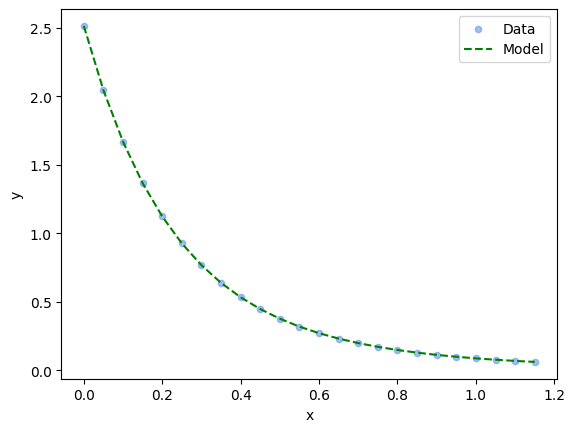

Residual Sum Square 1.6117193593589384e-08
Valor del chi2 del modelo  1.33


In [ ]:
params_lanczos3 = ([8.6816414977E-02, 8.4400777463E-01, 1.5825685901E+00], [9.5498101505E-01, 2.9515951832E+00, 4.9863565084E+00])
x_lanczos3 = np.arange(0, 1.16, 0.05)
y_lanczos3 = lanczos3(x_lanczos3, params_lanczos3)

datos_lanczos3 = np.array([
    2.5134E+00, 2.0443E+00, 1.6684E+00, 1.3664E+00, 1.1232E+00, 0.9269E+00, 0.7679E+00,
    0.6389E+00, 0.5338E+00, 0.4479E+00, 0.3776E+00, 0.3197E+00, 0.2720E+00, 0.2325E+00,
    0.1997E+00, 0.1723E+00, 0.1493E+00, 0.1301E+00, 0.1138E+00, 0.1000E+00, 0.0883E+00,
    0.0783E+00, 0.0698E+00, 0.0624E+00
])

sigma_lanczos3 = y_lanczos3 - datos_lanczos3
chi_lanczos3 = chi2(datos_lanczos3, y_lanczos3, sigma_lanczos3, params_lanczos3)

fig = plt.figure()

#fig.suptitle('Datos Lanczos3', fontweight ="bold")

plt.scatter(x_lanczos3, datos_lanczos3, s = 20, alpha = 0.6, color = 'cornflowerblue', label = 'Data')
plt.plot(x_lanczos3, y_lanczos3, '--', color = 'green', label ='Model')
plt.xlabel('x')
plt.ylabel('y')
#plt.title('Dificultad baja')
#plt.grid()
plt.legend()

plt.show()
print(f'Residual Sum Square {np.sum(np.power(y_lanczos3-datos_lanczos3, 2))}')
print(f'Valor del chi2 del modelo {chi_lanczos3: .3}')

## 4.2 Gauss1

$$f_3(x) = b_1 \exp(-b_2 x) + b_3 \exp\left(-\frac{(x - b_4)^2}{b_5^2}\right) + b_6 \exp\left(-\frac{(x - b_7)^2}{b_8^2}\right) + \epsilon$$

### Starting values and Certified Values

| Starting Values | Certified Values | Parameter            | Standard Deviation     |
|-----------------|------------------|----------------------|------------------------|
| **b1 =** 97.0    | 94.0             | 9.8778210871E+01     | 5.7527312730E-01       |
| **b2 =** 0.009   | 0.0105           | 1.0497276517E-02     | 1.1406289017E-04       |
| **b3 =** 100.0   | 99.0             | 1.0048990633E+02     | 5.8831775752E-01       |
| **b4 =** 65.0    | 63.0             | 6.7481111276E+01     | 1.0460593412E-01       |
| **b5 =** 20.0    | 25.0             | 2.3129773360E+01     | 1.7439951146E-01       |
| **b6 =** 70.0    | 71.0             | 7.1994503004E+01     | 6.2622793913E-01       |
| **b7 =** 178.0   | 180.0            | 1.7899805021E+02     | 1.2436988217E-01       |
| **b8 =** 16.5    | 20.0             | 1.8389389025E+01     | 2.0134312832E-01       |

**Residual Sum of Squares:** 1.3158222432E+03  
**Residual Standard Deviation:** 2.3317980180E+00  
**Degrees of Freedom:** 242  
**Number of Observations:** 250

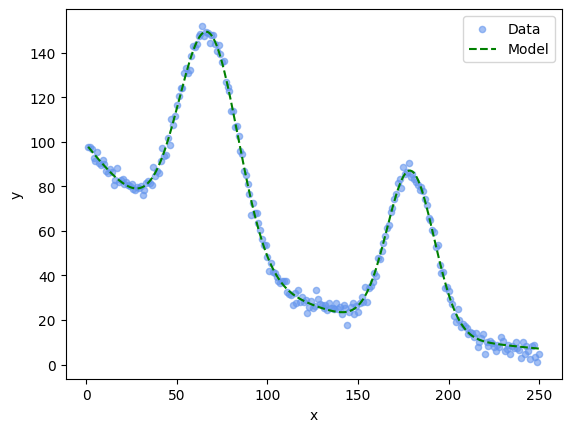

Residual Sum Square:1315.8222432033779
Valor del chi2 del modelo  1.03


In [ ]:
params_gauss1 = ([9.8778210871E+01, 1.0048990633E+02, 7.1994503004E+01], [1.0497276517E-02, 6.7481111276E+01, 2.3129773360E+01, 1.7899805021E+02, 1.8389389025E+01])
x_gauss1 = np.arange(1, 251, 1)
y_gauss1 = gauss1(x_gauss1, params_gauss1)

datos_gauss1 = np.array([
    97.62227, 97.80724, 96.62247, 92.59022, 91.23869,
    95.32704, 90.35040, 89.46235, 91.72520, 89.86916,
    86.88076, 85.94360, 87.60686, 86.25839, 80.74976,
    83.03551, 88.25837, 82.01316, 82.74098, 83.30034,
    81.27850, 81.85506, 80.75195, 80.09573, 81.07633,
    78.81542, 78.38596, 79.93386, 79.48474, 79.95942,
    76.10691, 78.39830, 81.43060, 82.48867, 81.65462,
    80.84323, 88.68663, 84.74438, 86.83934, 85.97739,
    91.28509, 97.22411, 93.51733, 94.10159, 101.91760,
    98.43134, 110.4214, 107.6628, 111.7288, 116.5115,
    120.7609, 123.9553, 124.2437, 130.7996, 133.2960,
    130.7788, 132.0565, 138.6584, 142.9252, 142.7215,
    144.1249, 147.4377, 148.2647, 152.0519, 147.3863,
    149.2074, 148.9537, 144.5876, 148.1226, 148.0144,
    143.8893, 140.9088, 143.4434, 139.3938, 135.9878,
    136.3927, 126.7262, 124.4487, 122.8647, 113.8557,
    113.7037, 106.8407, 107.0034, 102.46290, 96.09296,
    94.57555, 86.98824, 84.90154, 81.18023, 76.40117,
    67.09200, 72.67155, 68.10848, 67.99088, 63.34094,
    60.55253, 56.18687, 53.64482, 53.70307, 48.07893,
    42.21258, 45.65181, 41.69728, 41.24946, 39.21349,
    37.71696, 36.68395, 37.30393, 37.43277, 37.45012,
    32.64648, 31.84347, 31.39951, 26.68912, 32.25323,
    27.61008, 33.58649, 28.10714, 30.26428, 28.01648,
    29.11021, 23.02099, 25.65091, 28.50295, 25.23701,
    26.13828, 33.53260, 29.25195, 27.09847, 26.52999,
    25.52401, 26.69218, 24.55269, 27.71763, 25.20297,
    25.61483, 25.06893, 27.63930, 24.94851, 25.86806,
    22.48183, 26.90045, 25.39919, 17.90614, 23.76039,
    25.89689, 27.64231, 22.86101, 26.47003, 23.72888,
    27.54334, 30.52683, 28.07261, 34.92815, 28.29194,
    34.19161, 35.41207, 37.09336, 40.98330, 39.53923,
    47.80123, 47.46305, 51.04166, 54.58065, 57.53001,
    61.42089, 62.79032, 68.51455, 70.23053, 74.42776,
    76.59911, 81.62053, 83.42208, 79.17451, 88.56985,
    85.66525, 86.55502, 90.65907, 84.27290, 85.72220,
    83.10702, 82.16884, 80.42568, 78.15692, 79.79691,
    77.84378, 74.50327, 71.57289, 65.88031, 65.01385,
    60.19582, 59.66726, 52.95478, 53.87792, 44.91274,
    41.09909, 41.68018, 34.53379, 34.86419, 33.14787,
    29.58864, 27.29462, 21.91439, 19.08159, 24.90290,
    19.82341, 16.75551, 18.24558, 17.23549, 16.34934,
    13.71285, 14.75676, 13.97169, 12.42867, 14.35519,
    7.703309, 10.234410, 11.78315, 13.87768, 4.535700,
    10.059280, 8.424824, 10.533120, 9.602255, 7.877514,
    6.258121, 8.899865, 7.877754, 12.51191, 10.66205,
    6.035400, 6.790655, 8.783535, 4.600288, 8.400915,
    7.216561, 10.017410, 7.331278, 6.527863, 2.842001,
    10.325070, 4.790995, 8.377101, 6.264445, 2.706213,
    8.362329, 8.983658, 3.362571, 1.182746, 4.875359
])

sigma_gauss1 = y_gauss1 - datos_gauss1
chi_gauss1 = chi2(datos_gauss1, y_gauss1, sigma_gauss1, params_gauss1)

fig = plt.figure()

#fig.suptitle('Datos Gauss1', fontweight ="bold")

plt.scatter(x_gauss1, datos_gauss1, s = 20, alpha = 0.6, color = 'cornflowerblue', label = 'Data')
plt.plot(x_gauss1, y_gauss1, '--', color = 'green', label ='Model')
plt.xlabel('x')
plt.ylabel('y')
#plt.title('Dificultad baja')
#plt.grid()
plt.legend()

plt.show()
print(f'Residual Sum Square:{np.sum(np.power(y_gauss1-datos_gauss1, 2))}')
print(f'Valor del chi2 del modelo {chi_gauss1: .3}')

## 4.3 MGH17

$$f_4(x) = b_1 + b_2\exp(-b_4x)+b_3\exp(-b_5x)+ \epsilon$$

### Starting values and Certified Values

| Starting Values | Certified Values | Parameter            | Standard Deviation     |
|-----------------|------------------|----------------------|------------------------|
| **b1 =** 50      | 0.5              | 3.7541005211E-01     | 2.0723153551E-03       |
| **b2 =** 150     | 1.5              | 1.9358469127E+00     | 2.2031669222E-01       |
| **b3 =** -100    | -1               | -1.4646871366E+00    | 2.2175707739E-01       |
| **b4 =** 1       | 0.01             | 1.2867534640E-02     | 4.4861358114E-04       |
| **b5 =** 2       | 0.02             | 2.2122699662E-02     | 8.9471996575E-04       |

**Residual Sum of Squares:** 5.4648946975E-05  
**Residual Standard Deviation:** 1.3970497866E-03  
**Degrees of Freedom:** 28  
**Number of Observations:** 33

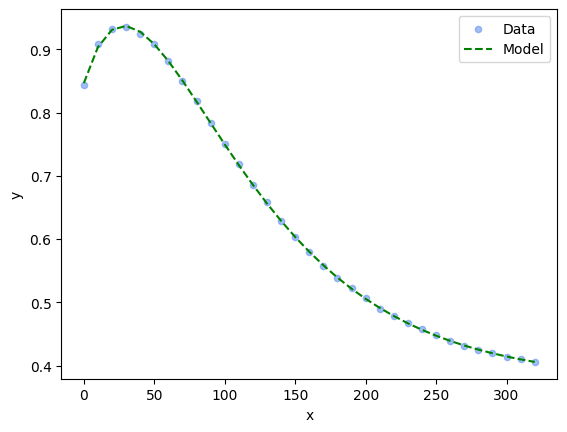

Residual Sum Square:5.464894697482846e-05
Valor de chi2 del modelo 1.18


In [ ]:
params_mgh17 = ([3.7541005211E-01, 1.9358469127E+00,  -1.4646871366E+00], [1.2867534640E-02, 2.2122699662E-02])
x_mgh17 = np.arange(0, 330, 10)
y_mgh17 = mgh17(x_mgh17, params_mgh17)
datos_mgh17 = np.array([
    8.440000E-01, 9.080000E-01, 9.320000E-01, 9.360000E-01, 9.250000E-01,
    9.080000E-01, 8.810000E-01, 8.500000E-01, 8.180000E-01, 7.840000E-01,
    7.510000E-01, 7.180000E-01, 6.850000E-01, 6.580000E-01, 6.280000E-01,
    6.030000E-01, 5.800000E-01, 5.580000E-01, 5.380000E-01, 5.220000E-01,
    5.060000E-01, 4.900000E-01, 4.780000E-01, 4.670000E-01, 4.570000E-01,
    4.480000E-01, 4.380000E-01, 4.310000E-01, 4.240000E-01, 4.200000E-01,
    4.140000E-01, 4.110000E-01, 4.060000E-01
])

sigma_mgh17 = datos_mgh17-y_mgh17
chi_mgh17 = chi2(datos_mgh17, y_mgh17, sigma_mgh17, params_mgh17)

fig = plt.figure()

#fig.suptitle('Datos MGH17', fontweight ="bold")

plt.scatter(x_mgh17, datos_mgh17, s = 20, alpha = 0.6, color = 'cornflowerblue', label = 'Data')
plt.plot(x_mgh17, y_mgh17, '--', color = 'green', label ='Model')
plt.xlabel('x')
plt.ylabel('y')
#plt.title('Dificultad media')
#plt.grid()
plt.legend()

plt.show()
a = ([1, 2, 3],[1, 2])
print(f'Residual Sum Square:{np.sum(np.power(y_mgh17-datos_mgh17, 2))}')
print(f'Valor de chi2 del modelo {chi_mgh17:.3}')

## 4.4 Rat42

$$ f_5(x)= \frac{b_1}{(1+\exp(b2-b_3x)}+\epsilon$$

### Starting Values and Certified Values

| Parameter | Start 1 | Start 2 | Certified Value         | Standard Deviation         |
|-----------|---------|---------|-------------------------|----------------------------|
| b1        | 100     | 75      | 7.2462237576E+01        | 1.7340283401E+00           |
| b2        | 1       | 2.5     | 2.6180768402E+00        | 8.8295217536E-02           |
| b3        | 0.1     | 0.07    | 6.7359200066E-02        | 3.4465663377E-03           |

### Additional Statistics

- **Residual Sum of Squares:** 8.0565229338E+00
- **Residual Standard Deviation:** 1.1587725499E+00
- **Degrees of Freedom:** 6
- **Number of Observations:** 9


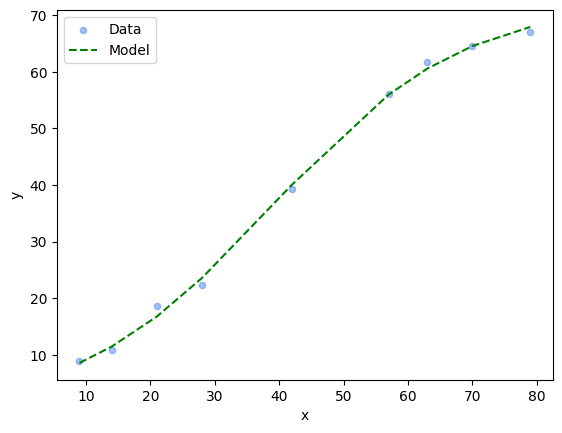

Residual Sum Square: 8.056522933811253
Valor de chi2 del modelo 1.5


In [ ]:
params_rat42 = ([7.2462237576E+01], [2.6180768402E+00, 6.7359200066E-02])
x_rat42 = np.array([9.000E0, 14.000E0, 21.000E0, 28.000E0, 42.000E0, 57.000E0, 63.000E0, 70.000E0, 79.000E0])
y_rat42 = rat42(x_rat42, params_rat42)
datos_rat42 = np.array([8.930E0, 10.800E0, 18.590E0, 22.330E0, 39.350E0, 56.110E0, 61.730E0, 64.620E0, 67.080E0])
sigma_rat42 = y_rat42-datos_rat42
chi_rat42 = chi2(datos_rat42, y_rat42, sigma_rat42, params_rat42)

fig = plt.figure()

#fig.suptitle('Datos RAT42', fontweight ="bold")

plt.scatter(x_rat42, datos_rat42, s = 20, alpha = 0.6, color = 'cornflowerblue', label = 'Data')
plt.plot(x_rat42, y_rat42, '--', color = 'green', label ='Model')
plt.xlabel('x')
plt.ylabel('y')
#plt.title('Dificultad alta')
#plt.grid()
plt.legend()

plt.show()
print(f'Residual Sum Square: {np.sum(np.power(y_rat42-datos_rat42, 2))}')
print(f'Valor de chi2 del modelo {chi_rat42:.3}')

# 5. Method Testing / Testing of Methods

## 5.1 Lanczos3

In [ ]:
tiempo_lanczos3 = []
params_nl_lanczos3 = [(0, 1.0), (1.0, 6.0), (3.0, 8.0)]
punto_inicio = [0.3, 5.5, 7.6]  #Primer Inicio
#punto_inicio = [0.7, 4.2, 6.3]  #Segundo Inicio
# b2 = 9.5498101505E-01
# b4 = 2.9515951832E+00
# b6 = 4.9863565084E+00

### GD

In [ ]:
inicio = time.time()
mc_gd(x_lanczos3, datos_lanczos3, lanczos3, sigma_lanczos3, bases_lanczos3, grad_lanczos3, params_nl_lanczos3, punto_inicio, eta = 0.1, filename = 'mc_gd_l')
fin = time.time()
tiempo_lanczos3.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Cantidad de reinicios cuyos parametrós salieron del intervalo: 0
Cantidad de veces que SVD no convergió en Mínimos Cuadrados Lineales: 0
Tiempo de ejecución: 286.87034010887146


In [ ]:
df = leer_resultados('mc_gd_l')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .5}')

Menor valor de chi2 alcanzado:  1.0576


### NR

In [ ]:
inicio = time.time()
mc_nr(x_lanczos3, datos_lanczos3, lanczos3, sigma_lanczos3, bases_lanczos3, grad_lanczos3, hess_lanczos3, params_nl_lanczos3, punto_inicio, filename = 'mc_nr_l')
fin = time.time()
tiempo_lanczos3.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Cantidad de reinicios cuyos parametrós salieron del intervalo: 22
Cantidad de veces que SVD no convergió en Mínimos Cuadrados Lineales: 10
Tiempo de ejecución: 440.97253799438477


In [ ]:
df = leer_resultados('mc_nr_l')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .5}')

Menor valor de chi2 alcanzado:  3.9526


### LM

In [ ]:
inicio = time.time()
mc_lm(x_lanczos3, datos_lanczos3, lanczos3, sigma_lanczos3, bases_lanczos3, grad_lanczos3, hess_lanczos3, params_nl_lanczos3, punto_inicio, filename = 'mc_lm_l')
fin = time.time()
tiempo_lanczos3.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Cantidad de reinicios cuyos parámetros salieron del intervalo: 614
Cantidad de veces que SVD no convergió en mínimos cuadrados lineales: 0
Tiempo de ejecución: 99.53992414474487


In [ ]:
df = leer_resultados('mc_lm_l')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .5}')

Menor valor de chi2 alcanzado:  3.3998


### AR

In [ ]:
inicio = time.time()
mc_ar(x_lanczos3, datos_lanczos3, sigma_lanczos3, bases_lanczos3, params_nl_lanczos3, filename = 'mc_ar_l')
fin = time.time()
tiempo_lanczos3.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Tiempo de ejecución: 195.88823699951172


In [ ]:
df = leer_resultados('mc_ar_l')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .5}')

Menor valor de chi2 alcanzado:  2.4988


### SA

In [ ]:
inicio = time.time()
mc_sa(x_lanczos3, datos_lanczos3, sigma_lanczos3, bases_lanczos3, params_nl_lanczos3, punto_inicio, filename = 'mc_sa_l')
fin = time.time()
tiempo_lanczos3.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Tiempo de ejecución: 201.35148406028748


In [ ]:
df = leer_resultados('mc_sa_l')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .5}')

Menor valor de chi2 alcanzado:  3.9939


### SCSA

In [ ]:
inicio = time.time()
mc_scsa(x_lanczos3, datos_lanczos3, sigma_lanczos3, bases_lanczos3, params_nl_lanczos3, punto_inicio, filename = 'mc_scsa_l')
fin = time.time()
tiempo_lanczos3.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Tiempo de ejecución: 223.32557249069214


In [ ]:
df = leer_resultados('mc_scsa_l')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .4}')

Menor valor de chi2 alcanzado:  2.084


### SCSAV

In [ ]:
inicio = time.time()
mc_scsav(x_lanczos3, datos_lanczos3, sigma_lanczos3, bases_lanczos3, params_nl_lanczos3, punto_inicio, std_number = 3, filename = 'mc_scsav_l')
fin = time.time()
tiempo_lanczos3.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Tiempo de ejecución: 494.57195258140564


In [ ]:
df = leer_resultados('mc_scsav_l')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .5}')

Menor valor de chi2 alcanzado:  2.4073


## 5.2 Gauss1

In [ ]:
tiempo_gauss1 = []
params_nl_gauss1 = [(0.0, 1.0), (65.0, 68.0), (20.0, 24.0), (177.0, 180.0), (16.0, 19.0)]
punto_inicio = [0.009, 65, 20, 178, 16.5]  #Primer Inicio
#punto_inicio = [0.0105, 63, 25, 180, 20]  #Segundo Inicio
# b2 = 1.0497276517E-02
# b4 = 6.7481111276E+01
# b5 = 2.3129773360E+01
# b7 = 1.7899805021E+02
# b8 = 1.8389389025E+01

### GD

In [ ]:
inicio = time.time()
mc_gd(x_gauss1, datos_gauss1, gauss1, sigma_gauss1, bases_gauss1, grad_gauss1, params_nl_gauss1, punto_inicio, eta = 0.1, filename ='mc_gd_g')
fin = time.time()
tiempo_gauss1.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Cantidad de reinicios cuyos parametrós salieron del intervalo: 1
Cantidad de veces que SVD no convergió en Mínimos Cuadrados Lineales: 0
Tiempo de ejecución: 580.478652715683


In [ ]:
df = leer_resultados('mc_gd_g')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .4}')

Menor valor de chi2 alcanzado:  3.789


### NR

In [ ]:
inicio = time.time()
mc_nr(x_gauss1, datos_gauss1, gauss1, sigma_gauss1, bases_gauss1, grad_gauss1, hess_gauss1, params_nl_gauss1, punto_inicio, filename = 'mc_nr_g')
fin = time.time()
tiempo_gauss1.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

/tmp/ipython-input-2638860263.py:46: RuntimeWarning: overflow encountered in exp
  return np.array([np.exp(-b2*x), np.exp(-np.power(x-b4, 2)/pow(b5, 2)), np.exp(-np.power(x-b7, 2)/pow(b8, 2))])


Cantidad de reinicios cuyos parametrós salieron del intervalo: 617
Cantidad de veces que SVD no convergió en Mínimos Cuadrados Lineales: 188
Tiempo de ejecución: 313.07468724250793


In [ ]:
df = leer_resultados('mc_nr_g')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .4}')

Menor valor de chi2 alcanzado:  1.0


### LM

In [ ]:
inicio = time.time()
mc_lm(x_gauss1, datos_gauss1, gauss1, sigma_gauss1, bases_gauss1, grad_gauss1, hess_gauss1, params_nl_gauss1, punto_inicio, filename = 'mc_lm_g')
fin = time.time()
tiempo_gauss1.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Cantidad de reinicios cuyos parámetros salieron del intervalo: 998
Cantidad de veces que SVD no convergió en mínimos cuadrados lineales: 0
Tiempo de ejecución: 4.801755905151367


In [ ]:
df = leer_resultados('mc_lm_g')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .4}')

Menor valor de chi2 alcanzado:  1.0


### AR

In [ ]:
inicio = time.time()
mc_ar(x_gauss1, datos_gauss1, sigma_gauss1, bases_gauss1, params_nl_gauss1, filename = 'mc_ar_g')
fin = time.time()
tiempo_gauss1.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Tiempo de ejecución: 258.6215834617615


In [ ]:
df = leer_resultados('mc_ar_g')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .4}')

Menor valor de chi2 alcanzado:  7.717


### SA

In [ ]:
inicio = time.time()
np.random.seed(12)
mc_sa(x_gauss1, datos_gauss1, sigma_gauss1, bases_gauss1, params_nl_gauss1, punto_inicio, filename = 'mc_sa_g')
fin = time.time()
tiempo_gauss1.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Tiempo de ejecución: 270.6847290992737


In [ ]:
df = leer_resultados('mc_sa_g')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .4}')

Menor valor de chi2 alcanzado:  4.21


### SCSA

In [ ]:
inicio = time.time()
mc_scsa(x_gauss1, datos_gauss1, sigma_gauss1, bases_gauss1, params_nl_gauss1, punto_inicio, filename = 'mc_scsa_g')
fin = time.time()
tiempo_gauss1.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Tiempo de ejecución: 293.3304054737091


In [ ]:
df_gauss1 = leer_resultados('mc_scsa_g')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .4}')

Menor valor de chi2 alcanzado:  4.21


### SCSAV

In [ ]:
inicio = time.time()
mc_scsav(x_gauss1, datos_gauss1, sigma_gauss1, bases_gauss1, params_nl_gauss1, punto_inicio, std_number = 3, filename = 'mc_scsav_g')
fin = time.time()
tiempo_gauss1.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Tiempo de ejecución: 2526.0597841739655


In [ ]:
df = leer_resultados('mc_scsav_g')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .4}')

Menor valor de chi2 alcanzado:  5.305


## 5.3 MGH17

In [ ]:
tiempo_mgh17 = []
params_nl_mgh17 = [(0.0, 1.0), (0.0, 1.0)]
#punto_inicio = [1, 2]  # Primer Inicio
punto_inicio = [0.01, 0.02]  #Segundo Inicio
# b4 = 1.2867534640E-02
# b5 = 2.2122699662E-02

### GD

In [ ]:
inicio = time.time()
mc_gd(x_mgh17, datos_mgh17, mgh17, sigma_mgh17, bases_mgh17, grad_mgh17, params_nl_mgh17, punto_inicio, eta = 0.0125, filename = 'mc_gd_m')
fin = time.time()
tiempo_mgh17.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Cantidad de reinicios cuyos parametrós salieron del intervalo: 0
Cantidad de veces que SVD no convergió en Mínimos Cuadrados Lineales: 0
Tiempo de ejecución: 274.0955364704132


In [ ]:
df = leer_resultados('mc_gd_m')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .4}')

Menor valor de chi2 alcanzado:  1.175


### NR

In [ ]:
inicio = time.time()
mc_nr(x_mgh17, datos_mgh17, mgh17, sigma_mgh17, bases_mgh17, grad_mgh17, hess_mgh17, params_nl_mgh17, punto_inicio, filename = 'mc_nr_m')
fin = time.time()
tiempo_mgh17.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

/tmp/ipython-input-2638860263.py:86: RuntimeWarning: overflow encountered in exp
  return np.array([np.ones_like(x), np.exp(-b4*x), np.exp(-b5*x)])


Cantidad de reinicios cuyos parametrós salieron del intervalo: 711
Cantidad de veces que SVD no convergió en Mínimos Cuadrados Lineales: 52
Tiempo de ejecución: 167.15664052963257


In [ ]:
df = leer_resultados('mc_nr_m')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .4}')

Menor valor de chi2 alcanzado:  1.398


### LM

In [ ]:
inicio = time.time()
mc_lm(x_mgh17, datos_mgh17, mgh17, sigma_mgh17, bases_mgh17, grad_mgh17, hess_mgh17, params_nl_mgh17, punto_inicio, filename = 'mc_lm_m')
fin = time.time()
tiempo_mgh17.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Cantidad de reinicios cuyos parámetros salieron del intervalo: 508
Cantidad de veces que SVD no convergió en mínimos cuadrados lineales: 0
Tiempo de ejecución: 234.15884637832642


In [ ]:
df = leer_resultados('mc_lm_m')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .4}')

Menor valor de chi2 alcanzado:  2.37


### AR

In [ ]:
inicio = time.time()
mc_ar(x_mgh17, datos_mgh17, sigma_mgh17, bases_mgh17, params_nl_mgh17, filename = 'mc_ar_m')
fin = time.time()
tiempo_mgh17.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Tiempo de ejecución: 176.5867302417755


In [ ]:
df = leer_resultados('mc_ar_m')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .4}')

Menor valor de chi2 alcanzado:  1.274


### SA

In [ ]:
inicio = time.time()
mc_sa(x_mgh17, datos_mgh17, sigma_mgh17, bases_mgh17, params_nl_mgh17, punto_inicio, filename = 'mc_sa_m')
fin = time.time()
tiempo_mgh17.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Tiempo de ejecución: 198.1359601020813


In [ ]:
df = leer_resultados('mc_sa_m')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .4}')

Menor valor de chi2 alcanzado:  1.121


### SCSA

In [ ]:
inicio = time.time()
mc_scsa(x_mgh17, datos_mgh17, sigma_mgh17, bases_mgh17, params_nl_mgh17, punto_inicio, filename = 'mc_scsa_m')
fin = time.time()
tiempo_mgh17.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Tiempo de ejecución: 208.11263394355774


In [ ]:
df = leer_resultados('mc_scsa_m')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .4}')

Menor valor de chi2 alcanzado:  2.441


### SCSAV

In [ ]:
inicio = time.time()
mc_scsav(x_mgh17, datos_mgh17, sigma_mgh17, bases_mgh17, params_nl_mgh17, punto_inicio, std_number = 3, filename = 'mc_scsav_m')
fin = time.time()
tiempo_mgh17.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Tiempo de ejecución: 399.3688473701477


In [ ]:
df = leer_resultados('mc_scsav_m')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .4}')

Menor valor de chi2 alcanzado:  1.111


## 5.4 RAT42

In [ ]:
tiempo_rat42 = []
params_nl_rat42 = [(0.0, 5.0), (0.0, 1.0)]
punto_inicio = [1, 0.1]  # Primer Inicio
#punto_inicio = [2.5, 0.07]  #Segundo Inicio
# b2 = 2.6180768402E+00
# b3 = 6.7359200066E-02

### GD

In [ ]:
inicio = time.time()
#np.random.seed(555)
mc_gd(x_rat42, datos_rat42, rat42, sigma_rat42, bases_rat42, grad_rat42, params_nl_rat42, punto_inicio, eta =0.1, filename = 'mc_gd_r')
fin = time.time()
tiempo_rat42.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Cantidad de reinicios cuyos parametrós salieron del intervalo: 2
Cantidad de veces que SVD no convergió en Mínimos Cuadrados Lineales: 0
Tiempo de ejecución: 226.69489169120789


In [ ]:
df = leer_resultados('mc_gd_r')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .4}')

Menor valor de chi2 alcanzado:  1.237


### NR

In [ ]:
inicio = time.time()
mc_nr(x_rat42, datos_rat42, rat42, sigma_rat42, bases_rat42, grad_rat42, hess_rat42, params_nl_rat42, punto_inicio, filename = 'mc_nr_r')
fin = time.time()
tiempo_rat42.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

/tmp/ipython-input-936534760.py:37: RuntimeWarning: overflow encountered in divide
  s_inv[mask] = 1.0 / s[mask]


Cantidad de reinicios cuyos parametrós salieron del intervalo: 50
Cantidad de veces que SVD no convergió en Mínimos Cuadrados Lineales: 0
Tiempo de ejecución: 288.17479848861694


In [ ]:
df = leer_resultados('mc_nr_r')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .4}')

Menor valor de chi2 alcanzado:  1.237


### LM

In [ ]:
inicio = time.time()
mc_lm(x_rat42, datos_rat42, rat42, sigma_rat42, bases_rat42, grad_rat42, hess_rat42, params_nl_rat42, punto_inicio, filename = 'mc_lm_r')
fin = time.time()
tiempo_rat42.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Cantidad de reinicios cuyos parámetros salieron del intervalo: 861
Cantidad de veces que SVD no convergió en mínimos cuadrados lineales: 0
Tiempo de ejecución: 24.420433282852173


In [ ]:
df = leer_resultados('mc_lm_r')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .4}')

Menor valor de chi2 alcanzado:  1.237


### AR

In [ ]:
inicio = time.time()
mc_ar(x_rat42, datos_rat42, sigma_rat42, bases_rat42, params_nl_rat42, filename = 'mc_ar_r')
fin = time.time()
tiempo_rat42.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Tiempo de ejecución: 146.39582562446594


In [ ]:
df = leer_resultados('mc_ar_r')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .4}')

Menor valor de chi2 alcanzado:  1.24


### SA

In [ ]:
inicio = time.time()
np.random.seed(5)
mc_sa(x_rat42, datos_rat42, sigma_rat42, bases_rat42, params_nl_rat42, punto_inicio, filename = 'mc_sa_r')
fin = time.time()
tiempo_rat42.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Tiempo de ejecución: 185.35690569877625


In [ ]:
df = leer_resultados('mc_sa_r')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .4}')

Menor valor de chi2 alcanzado:  1.248


### SCSA

In [ ]:
inicio = time.time()
mc_scsa(x_rat42, datos_rat42, sigma_rat42, bases_rat42, params_nl_rat42, punto_inicio, filename = 'mc_scsa_r')
fin = time.time()
tiempo_rat42.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Tiempo de ejecución: 196.59628438949585


In [ ]:
df = leer_resultados('mc_scsa_r')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .4}')

Menor valor de chi2 alcanzado:  1.273


### SCSAV

In [ ]:
inicio = time.time()
mc_scsav(x_rat42, datos_rat42, sigma_rat42, bases_rat42, params_nl_rat42, punto_inicio, std_number = 3, filename = 'mc_scsav_r')
fin = time.time()
tiempo_rat42.append(fin-inicio)
print(f'Tiempo de ejecución: {fin-inicio}')

Tiempo de ejecución: 276.7434432506561


In [ ]:
df = leer_resultados('mc_scsav_r')
chi = df['chi'].min()
print(f'Menor valor de chi2 alcanzado: {chi : .4}')

Menor valor de chi2 alcanzado:  1.241


# 6. Results

## 6.1 Lanczos 3

In [ ]:
x = x_lanczos3
y = y_lanczos3
datos = datos_lanczos3

archivos = ['mc_gd_l', 'mc_nr_l', 'mc_lm_l', 'mc_ar_l', 'mc_sa_l','mc_scsa_l', 'mc_scsav_l']
p_l = []
p_nl = []
ajustes = []
chi = []

for name in archivos:
  df = leer_resultados(name)
  idx_min = df['chi'].idxmin()
  beta_optimo = df.loc[idx_min, 'beta']
  gamma_optimo = df.loc[idx_min, 'gamma']
  chi_optimo = df.loc[idx_min, 'chi']
  ajuste_optimo = lanczos3(x, [beta_optimo, gamma_optimo])
  ajustes.append(ajuste_optimo)
  chi.append(chi_optimo)
  p_l.append(beta_optimo)
  p_nl.append(gamma_optimo)

resultados_lanczos3 = pd.DataFrame({
    'Método': archivos,
    'Tiempo de ejecución': tiempo_lanczos3,
    'Chi2': chi,
    'P_L': p_l,
    'P_NL': p_nl
})

In [ ]:
P_f1 = np.concatenate(params_lanczos3)
resultados_lanczos3 = resultados_lanczos3.copy()

resultados_lanczos3['D_P'] = resultados_lanczos3.apply(lambda row: np.array(row['P_L'] + row['P_NL']) - P_f1, axis=1)
resultados_lanczos3['NDEV'] = resultados_lanczos3['D_P'].apply(np.linalg.norm)

resultados_lanczos3 = resultados_lanczos3.drop(['P_L', 'P_NL', 'D_P'], axis=1)
resultados_lanczos3['Tiempo de ejecución'] = resultados_lanczos3['Tiempo de ejecución']/resultados_lanczos3['Tiempo de ejecución'].max()

NDM_P = []
archivos = ['mc_gd_l', 'mc_nr_l', 'mc_lm_l', 'mc_ar_l', 'mc_sa_l', 'mc_scsa_l', 'mc_scsav_l']

for name in archivos:
    df = leer_resultados(name)
    resul = df.copy()

    resul['D_P'] = resul.apply(lambda row: np.array(row['beta'] + row['gamma']) - P_f1, axis=1)
    resul_mc_ar = resul.drop(['beta', 'gamma'], axis=1)
    resul['NDEV'] = resul['D_P'].apply(np.linalg.norm)

    modulo = []
    for i in range(1000):
        resul_i = resul[resul['i'] == i]
        indice = resul_i['chi'].idxmin()
        modulo.append(resul_i.loc[indice, 'NDEV'])

    modulo = np.array(modulo)
    NDM_P.append(np.mean(modulo))

resultados_lanczos3['NDMEV'] = NDM_P

In [ ]:
resultados_lanczos3

,Método,Tiempo de ejecución,Chi2,NDEV,NDMEV
0,mc_gd_l,0.580038,1.057606,0.039484,1.435192e+00
1,mc_nr_l,0.891625,3.952615,0.131212,1.831639e+07
2,mc_lm_l,0.201265,3.399840,0.318043,6.654312e+06
3,mc_ar_l,0.396076,2.498832,0.004392,9.722976e-01
4,mc_sa_l,0.407123,3.993888,0.320698,1.004137e+00
5,mc_scsa_l,0.451553,2.084459,0.095555,8.136242e-01
6,mc_scsav_l,1.000000,2.407289,0.134385,9.332811e-01


In [ ]:
resultados_lanczos3.to_excel("resultados_lanczos3.xlsx", index=False)

## 6.2 Gauss1

In [ ]:
x = x_gauss1
y = y_gauss1
datos = datos_gauss1

archivos = ['mc_gd_g', 'mc_nr_g', 'mc_lm_g', 'mc_ar_g', 'mc_sa_g','mc_scsa_g', 'mc_scsav_g']
p_l = []
p_nl = []
ajustes = []
chi = []


for name in archivos:
  df = leer_resultados(name)
  idx_min = df['chi'].idxmin()
  beta_optimo = df.loc[idx_min, 'beta']
  gamma_optimo = df.loc[idx_min, 'gamma']
  chi_optimo = df.loc[idx_min, 'chi']
  ajuste_optimo = gauss1(x, [beta_optimo, gamma_optimo])
  ajustes.append(ajuste_optimo)
  chi.append(chi_optimo)
  p_l.append(beta_optimo)
  p_nl.append(gamma_optimo)

resultados_gauss1 = pd.DataFrame({
    'Método': archivos,
    'Tiempo de ejecución': tiempo_gauss1,
    'Chi2': chi,
    'P_L': p_l,
    'P_NL': p_nl
})

In [ ]:
P_f1 = np.concatenate(params_gauss1)
resultados_gauss1 = resultados_gauss1.copy()

resultados_gauss1['D_P'] = resultados_gauss1.apply(lambda row: np.array(row['P_L'] + row['P_NL']) - P_f1, axis=1)
resultados_gauss1['NDEV'] = resultados_gauss1['D_P'].apply(np.linalg.norm)

resultados_gauss1 = resultados_gauss1.drop(['P_L', 'P_NL', 'D_P'], axis=1)
resultados_gauss1['Tiempo de ejecución'] = resultados_gauss1['Tiempo de ejecución']/resultados_gauss1['Tiempo de ejecución'].max()

NDM_P = []
archivos = ['mc_gd_g', 'mc_nr_g', 'mc_lm_g', 'mc_ar_g', 'mc_sa_g', 'mc_scsa_g', 'mc_scsav_g']

for name in archivos:
    df = leer_resultados(name)
    resul = df.copy()

    resul['D_P'] = resul.apply(lambda row: np.array(row['beta'] + row['gamma']) - P_f1, axis=1)
    resul_mc_ar = resul.drop(['beta', 'gamma'], axis=1)
    resul['NDEV'] = resul['D_P'].apply(np.linalg.norm)

    modulo = []
    for i in range(1000):
        resul_i = resul[resul['i'] == i]
        indice = resul_i['chi'].idxmin()
        modulo.append(resul_i.loc[indice, 'NDEV'])

    modulo = np.array(modulo)
    NDM_P.append(np.mean(modulo))

resultados_gauss1['NDMEV'] = NDM_P

In [ ]:
resultados_gauss1

,Método,Tiempo de ejecución,Chi2,NDEV,NDMEV
0,mc_gd_g,0.229796,3.788753,0.492263,21.151856
1,mc_nr_g,0.123938,1.000460,0.039167,59627.292044
2,mc_lm_g,0.001901,1.000489,0.036718,106.561494
3,mc_ar_g,0.102381,7.716861,3.680959,8.000016
4,mc_sa_g,0.107157,4.210146,1.666130,8.347063
5,mc_scsa_g,0.116122,4.232848,0.930514,11.179332
6,mc_scsav_g,1.000000,5.305337,2.703937,16.975565


In [ ]:
resultados_gauss1.to_excel("resultados_gauss1.xlsx", index=False)

## 6.3 MGH17

In [ ]:
x = x_mgh17
y = y_mgh17
datos = datos_mgh17

archivos = ['mc_gd_m', 'mc_nr_m', 'mc_lm_m', 'mc_ar_m', 'mc_sa_m','mc_scsa_m', 'mc_scsav_m']
p_l = []
p_nl = []
ajustes = []
chi = []

for name in archivos:
  df = leer_resultados(name)
  idx_min = df['chi'].idxmin()
  beta_optimo = df.loc[idx_min, 'beta']
  gamma_optimo = df.loc[idx_min, 'gamma']
  chi_optimo = df.loc[idx_min, 'chi']
  ajuste_optimo = mgh17(x, [beta_optimo, gamma_optimo])
  ajustes.append(ajuste_optimo)
  chi.append(chi_optimo)
  p_l.append(beta_optimo)
  p_nl.append(gamma_optimo)

resultados_mgh17 = pd.DataFrame({
    'Método': archivos,
    'Tiempo de ejecución': tiempo_mgh17,
    'Chi2': chi,
    'P_L': p_l,
    'P_NL': p_nl
})

In [ ]:
P_f1 = np.concatenate(params_mgh17)
resultados_mgh17 = resultados_mgh17.copy()

resultados_mgh17['D_P'] = resultados_mgh17.apply(lambda row: np.array(row['P_L'] + row['P_NL']) - P_f1, axis=1)
resultados_mgh17['NDEV'] = resultados_mgh17['D_P'].apply(np.linalg.norm)

resultados_mgh17 = resultados_mgh17.drop(['P_L', 'P_NL', 'D_P'], axis=1)
resultados_mgh17['Tiempo de ejecución'] = resultados_mgh17['Tiempo de ejecución']/resultados_mgh17['Tiempo de ejecución'].max()

NDM_P = []
archivos = ['mc_gd_m', 'mc_nr_m', 'mc_lm_m', 'mc_ar_m', 'mc_sa_m', 'mc_scsa_m', 'mc_scsav_m']

for name in archivos:
    df = leer_resultados(name)
    resul = df.copy()

    resul['D_P'] = resul.apply(lambda row: np.array(row['beta'] + row['gamma']) - P_f1, axis=1)
    resul_mc_ar = resul.drop(['beta', 'gamma'], axis=1)
    resul['NDEV'] = resul['D_P'].apply(np.linalg.norm)

    modulo = []
    for i in range(1000):
        resul_i = resul[resul['i'] == i]
        indice = resul_i['chi'].idxmin()
        modulo.append(resul_i.loc[indice, 'NDEV'])

    modulo = np.array(modulo)
    NDM_P.append(np.mean(modulo))

resultados_mgh17['NDMEV'] = NDM_P

In [ ]:
resultados_mgh17

,Método,Tiempo de ejecución,Chi2,NDEV,NDMEV
0,mc_gd_m,0.686322,1.175361,0.260104,605.299937
1,mc_nr_m,0.418552,1.397743,5.494652,112603.429834
2,mc_lm_m,0.586322,2.369684,1.301491,977.215666
3,mc_ar_m,0.442165,1.273623,4.948412,10.564915
4,mc_sa_m,0.496123,1.120869,0.128571,5.037100
5,mc_scsa_m,0.521104,2.441243,6.230707,2.740966
6,mc_scsav_m,1.000000,1.111168,4.834469,3.876770


In [ ]:
resultados_mgh17.to_excel("resultados_mgh17.xlsx", index=False)

## 6.4 RAT42

In [ ]:
x = x_rat42
y = y_rat42
datos = datos_rat42

archivos = ['mc_gd_r', 'mc_nr_r', 'mc_lm_r', 'mc_ar_r', 'mc_sa_r','mc_scsa_r', 'mc_scsav_r']
p_l = []
p_nl = []
ajustes = []
chi = []

for name in archivos:
  df = leer_resultados(name)
  idx_min = df['chi'].idxmin()
  beta_optimo = df.loc[idx_min, 'beta']
  gamma_optimo = df.loc[idx_min, 'gamma']
  chi_optimo = df.loc[idx_min, 'chi']
  ajuste_optimo = rat42(x, [beta_optimo, gamma_optimo])
  ajustes.append(ajuste_optimo)
  chi.append(chi_optimo)
  p_l.append(beta_optimo)
  p_nl.append(gamma_optimo)

resultados_rat42 = pd.DataFrame({
    'Método': archivos,
    'Tiempo de ejecución': tiempo_rat42,
    'Chi2': chi,
    'P_L': p_l,
    'P_NL': p_nl
})

In [ ]:
P_f1 = np.concatenate(params_rat42)
resultados_rat42 = resultados_rat42.copy()

resultados_rat42['D_P'] = resultados_rat42.apply(lambda row: np.array(row['P_L'] + row['P_NL']) - P_f1, axis=1)
resultados_rat42['NDEV'] = resultados_rat42['D_P'].apply(np.linalg.norm)

resultados_rat42 = resultados_rat42.drop(['P_L', 'P_NL', 'D_P'], axis=1)
resultados_rat42['Tiempo de ejecución'] = resultados_rat42['Tiempo de ejecución']/resultados_rat42['Tiempo de ejecución'].max()

NDM_P = []
archivos = ['mc_gd_r', 'mc_nr_r', 'mc_lm_r', 'mc_ar_r', 'mc_sa_r', 'mc_scsa_r', 'mc_scsav_r']

for name in archivos:
    df = leer_resultados(name)
    resul = df.copy()

    resul['D_P'] = resul.apply(lambda row: np.array(row['beta'] + row['gamma']) - P_f1, axis=1)
    resul_mc_ar = resul.drop(['beta', 'gamma'], axis=1)
    resul['NDEV'] = resul['D_P'].apply(np.linalg.norm)

    modulo = []
    for i in range(1000):
        resul_i = resul[resul['i'] == i]
        indice = resul_i['chi'].idxmin()
        modulo.append(resul_i.loc[indice, 'NDEV'])

    modulo = np.array(modulo)
    NDM_P.append(np.mean(modulo))

resultados_rat42['NDMEV'] = NDM_P

In [ ]:
resultados_rat42

,Método,Tiempo de ejecución,Chi2,NDEV,NDMEV
0,mc_gd_r,0.786658,1.237285,0.017062,26.769546
1,mc_nr_r,1.000000,1.237309,0.021282,25.615033
2,mc_lm_r,0.084742,1.237297,0.020034,33.150508
3,mc_ar_r,0.508011,1.239662,0.013678,1.845845
4,mc_sa_r,0.643210,1.248495,0.048338,1.776830
5,mc_scsa_r,0.682212,1.273196,0.074426,2.011643
6,mc_scsav_r,0.960332,1.241363,0.035705,7.552839


In [ ]:
resultados_rat42.to_excel("resultados_rat42.xlsx", index=False)